# Convolutional Neural Networks

In this notebook we're going to explore handwritten digit recognition task using MNIST database and CNNs

In [1]:
import numpy as np
import pandas as pd

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras import backend as K
from keras.utils.vis_utils import model_to_dot

from IPython.display import SVG

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


Set style

In [2]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["figure.figsize"] = (10, 8)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

Just for the sake of reproducibility

In [3]:
np.random.seed(41)

# Data

In this tutorial we're going to use MNIST dataset with handwritten digits.

## MNIST overview

Let's download MNIST dataset. There is a special function in Keras for that purpose (because MNIST is extremely popular)

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(len(X_train), 'train samples')
print(len(X_test), 'test samples')

11460608/11490434 [============================>.] - ETA: 0s60000 train samples
10000 test samples


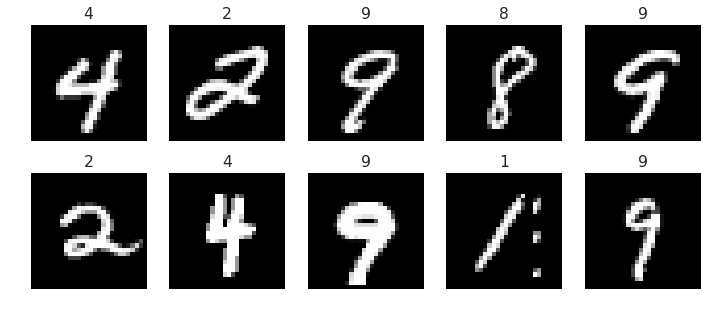

In [5]:
plt.figure(figsize=(12, 5))
for num, i in enumerate(np.random.choice(len(X_train), 10)):
    plt.subplot(2, 5, num + 1)
    plt.imshow(X_train[i], cmap="Greys_r")
    plt.axis("off")
    plt.title(str(y_train[i]))

Let's see objects are distributed among classes

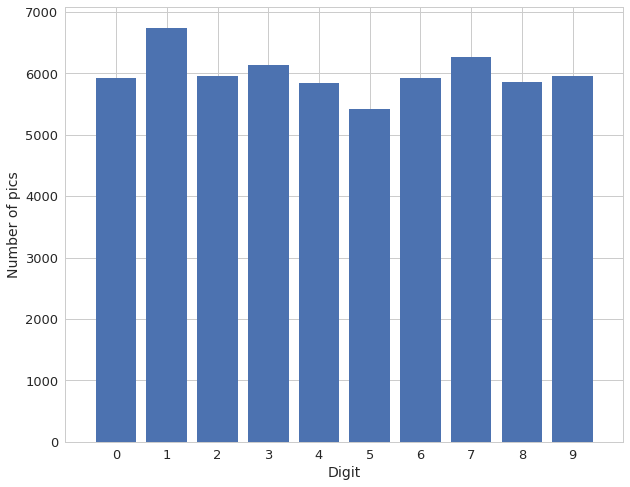

In [6]:
x_bars, y_bars = np.unique(y_train, return_counts=True)
plt.bar(x_bars, y_bars)
plt.xlim([-1, 10])
plt.xticks(np.arange(0, 10))
plt.xlabel("Digit", fontsize=14)
plt.ylabel("Number of pics", fontsize=14)
plt.show()

As one can see, the task is pretty balanced

## Data preparation

First of all, let's predefine image parameters:
* **img_rows, img_cols** $-$ 2D dimension of a pictures; for MNIST it is $28 \times 28$
* **nb_classes** $-$ number of classes (digits in our case)

In [7]:
img_rows, img_cols = 28, 28
nb_classes = 10

Theano and Tensorflow both are tensor-based libraries. It means that all objects inside it, all inputs and outputs are **tensors**. One can treat tensor as a simple multidimensional array.

The thing that is different in Theano and Tensorflow is order of these dimensions inside tensor.

With Theano yo're going to have 4-dimensional tensor with the following dimensions: **(Objects, Channels, Image rows,Image columns)**. Assume that $\text{X_train}$ is our tensor. Then $\text{X_train}[0]$ gives you one trainig object - it is an image with few channels in general case. $\text{X_train}[0][0]$ gives you the first channel of the first object. And so on. The logic of tensors should be clear now.

In Tensorflow the order is the following: **(Objects, Image rows,Image columns, Channels)**

Thus we need to check what dimension order do we have and reshape our tensor in accordance with it:

In [8]:
if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

Here we have grayscale image and thus the number of the channels is $1$. Here I used Tensorflow library with the corresponding order of dimensions

In [9]:
print('X_train shape:', X_train.shape)

X_train shape: (60000, 28, 28, 1)


Tensorflow prefers to work with $\text{float32}$ data type. So the next step is to cast data. Also let's have our data in $[0; 1]$ interval $-$ it's common choice for grayscale images.

In [10]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Last step is to convert labels into [One-Hot Encoding](https://en.wikipedia.org/wiki/One-hot) because we're going to learn them through the softmax layer in CNN

In [11]:
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

# Dense baseline model

First of all, let's build MLP model and see how it performs

In [12]:
model_dense = Sequential()

In [13]:
model_dense.add(Dense(128, input_shape=(img_rows * img_cols,), activation="relu"))
model_dense.add(Dropout(0.5))
model_dense.add(Dense(128, activation="relu"))
model_dense.add(Dropout(0.5))
model_dense.add(Dense(128, activation="relu"))
model_dense.add(Dropout(0.5))
model_dense.add(Dense(nb_classes, activation="softmax"))

Our model the the following architercture

In [14]:
model_dense.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total para

Compile model

In [15]:
model_dense.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

## Training

In [16]:
hist = model_dense.fit(X_train.reshape((len(X_train), img_cols * img_rows)), y_train, 
                       validation_data = (X_test.reshape((len(X_test), img_cols * img_rows)), y_test), 
                       epochs=20, batch_size=128)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s - loss: 0.7976 - acc: 0.7406 - val_loss: 0.2202 - val_acc: 0.9371
Epoch 2/20
60000/60000 [==============================] - 2s - loss: 0.3609 - acc: 0.8989 - val_loss: 0.1661 - val_acc: 0.9518
Epoch 3/20
60000/60000 [==============================] - 2s - loss: 0.2954 - acc: 0.9190 - val_loss: 0.1456 - val_acc: 0.9578
Epoch 4/20
60000/60000 [==============================] - 2s - loss: 0.2541 - acc: 0.9307 - val_loss: 0.1326 - val_acc: 0.9627
Epoch 5/20
60000/60000 [==============================] - 2s - loss: 0.2300 - acc: 0.9363 - val_loss: 0.1229 - val_acc: 0.9658
Epoch 6/20
60000/60000 [==============================] - 2s - loss: 0.2199 - acc: 0.9405 - val_loss: 0.1173 - val_acc: 0.9655
Epoch 7/20
60000/60000 [==============================] - 2s - loss: 0.2040 - acc: 0.9436 - val_loss: 0.1076 - val_acc: 0.9694
Epoch 8/20
60000/60000 [==============================] - 2s 

## Evaluation

Learning process visualization

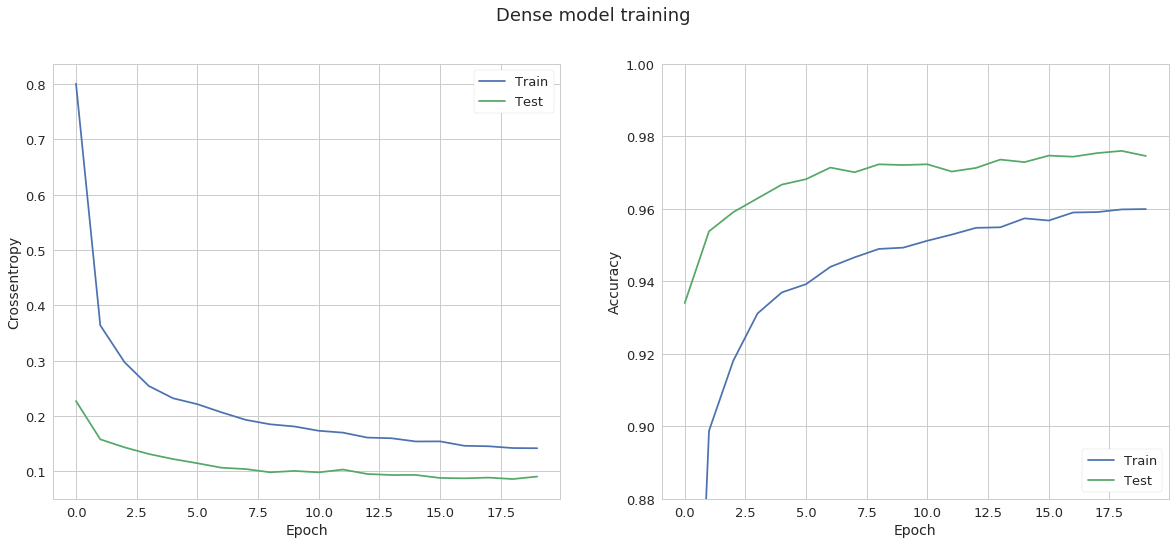

In [17]:
plt.figure(figsize=(20, 8))
plt.suptitle("Dense model training", fontsize=18)
plt.subplot(121)
plt.plot(hist.history["loss"], label="Train")
plt.plot(hist.history["val_loss"], label="Test")
plt.grid("on")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Crossentropy", fontsize=14)
plt.legend(loc="upper right")
plt.subplot(122)
plt.plot(hist.history["acc"], label="Train")
plt.grid("on")
plt.plot(hist.history["val_acc"], label="Test")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(loc="lower right")
plt.ylim([0.88, 1.0]);

Table to store the results of the experiments

In [18]:
score_train = model_dense.evaluate(X_train.reshape((len(X_train), img_cols * img_rows)), y_train, verbose=0)
score_test = model_dense.evaluate(X_test.reshape((len(X_test), img_cols * img_rows)), y_test, verbose=0)

In [19]:
results = pd.DataFrame(columns=["Accuracy Train", "Accuracy Test", "Loss Train", "Loss Test"])
results.loc[len(results)] = np.array([score_train[1], score_test[1], score_train[0], score_test[0]])
results.index = ["MLP"]

In [20]:
results

,Accuracy Train,Accuracy Test,Loss Train,Loss Test
MLP,0.9862,0.9746,0.045773,0.090305


# Building CNN model

Now it's time to build the model step-by-step

In [21]:
model_cnn = Sequential()

Out model is going to be *Sequential* which means that every new added layer will be automatically connected to the previous one.

Firstly, let's define hyperparameters of the network:
* **filters** $-$ number of filters (or kernels) to use in every layer; in fact this is the same as having multiple channels in the image
* **pool_size** $-$ size of the pooling window
* **kernel_size** $-$ size of the convolutional filters

In [22]:
filters = 32
kernel_size = (3, 3)
pool_size = (2, 2)

Now let's add first layer of the network. It is 2D Convolutional layer. Only unexplained thing here is *padding*. This is the parameter that defines how should we pad the data after applying convolutions. $\text{padding} = \text{'valid'}$ means that we're not going to pad images and the dimension of it is going to shrink from layer to layer.

In [23]:
model_cnn.add(Convolution2D(filters=filters, 
                            kernel_size=kernel_size,
                            padding="valid",
                            input_shape=input_shape))

Next step is to add nonlinearity to enable our network to learn complex dependencies. We're going to use ReLU activation function because it is less exposed to vanishing gradient problem and faster to train.

In [24]:
model_cnn.add(Activation('relu'))

Let's stack one more Convolution layer on top of that:

In [25]:
model_cnn.add(Convolution2D(filters=filters, 
                            kernel_size=kernel_size,
                            padding="valid"))
model_cnn.add(Activation('relu'))

Now it's time to apply pooling. Note that the strategies of combining convolutional and pooling layers may be different. For further details see [here](http://cs231n.stanford.edu/)

In [26]:
model_cnn.add(MaxPooling2D(pool_size=pool_size))

At this point we consider that we've already distinguish some meaningful features from the pictures. So it's time to classify them. For that purpose the common approach is to append fully-connected part. 

But before that we need to pull all the obtained feature into one vector so that one object has 1D-vector of features. It is done by means of $\text{Flatten}$ layer.

In [27]:
model_cnn.add(Flatten())

Now let's add FC part with the [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) to avoid overfitting.

In [28]:
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(128, activation="relu"))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(nb_classes, activation="softmax"))

The final layer here is usual $\text{Softmax}$ with the number of classe. So as the output of the network we observe the probability of each class.

Now let's compile our model.
* **optimizer** $-$ here we use accelerated gradient descent algorithm with special adaptive way of choosing learning rate; for more details see this great [overview](http://sebastianruder.com/optimizing-gradient-descent/) of gradient descent optimization algorithms.
* **loss** $-$ usual choice for multiclass classification is softmax output layer in combination with categotical crossentropy loss function which is
$$
\mathcal{L}(\text{true}, \text{pred}) = -\sum_{j=1}^{k}\text{true}_j \cdot \log \{\text{pred}_j\}
$$
* **metrics** $-$ additional metrics that we're going to trace while training; it doesn't influence training process at all

In [29]:
model_cnn.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Let's take a look at our final model now:

In [30]:
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4608)              0         
__________

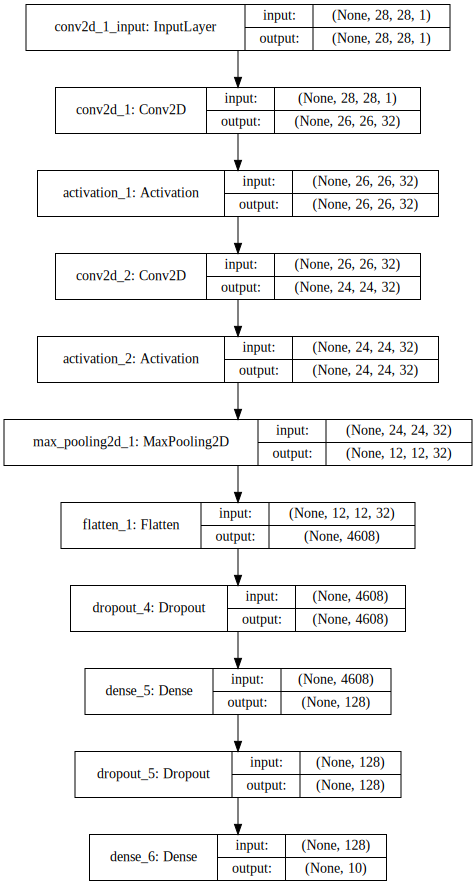

In [31]:
SVG(model_to_dot(model_cnn, show_shapes=True).create(prog='dot', format='svg'))

## Training

Training parameters are the following:
* nb_epoch $-$ number of epochs to train. here we choose 12; one may condiser using some stopping criterias
* **batch_size** $-$ parameter that controls how frequent do we update gradient; with $\text{batch_size}=1$ optimization is nothing but pure Stohastic Gradient Descent (update gradient after passing each one object); with $\text{batch_size}=\textit{number of objects}$ it will be usual Gradient Descent which updates gradient only after passing all objects. Choosing value between this two one can control speed and convergence of training process.

In [32]:
batch_size = 128
epochs = 5

Train!

In [33]:
hist = model_cnn.fit(X_train, y_train, 
                     batch_size=batch_size, 
                     epochs=epochs,
                     validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 4s - loss: 0.3012 - acc: 0.9083 - val_loss: 0.0619 - val_acc: 0.9810
Epoch 2/5
60000/60000 [==============================] - 4s - loss: 0.1086 - acc: 0.9675 - val_loss: 0.0460 - val_acc: 0.9852
Epoch 3/5
60000/60000 [==============================] - 4s - loss: 0.0864 - acc: 0.9739 - val_loss: 0.0404 - val_acc: 0.9871
Epoch 4/5
60000/60000 [==============================] - 4s - loss: 0.0715 - acc: 0.9782 - val_loss: 0.0327 - val_acc: 0.9892
Epoch 5/5
60000/60000 [==============================] - 4s - loss: 0.0648 - acc: 0.9798 - val_loss: 0.0327 - val_acc: 0.9883


## Evaluation

Visualization of learning process:

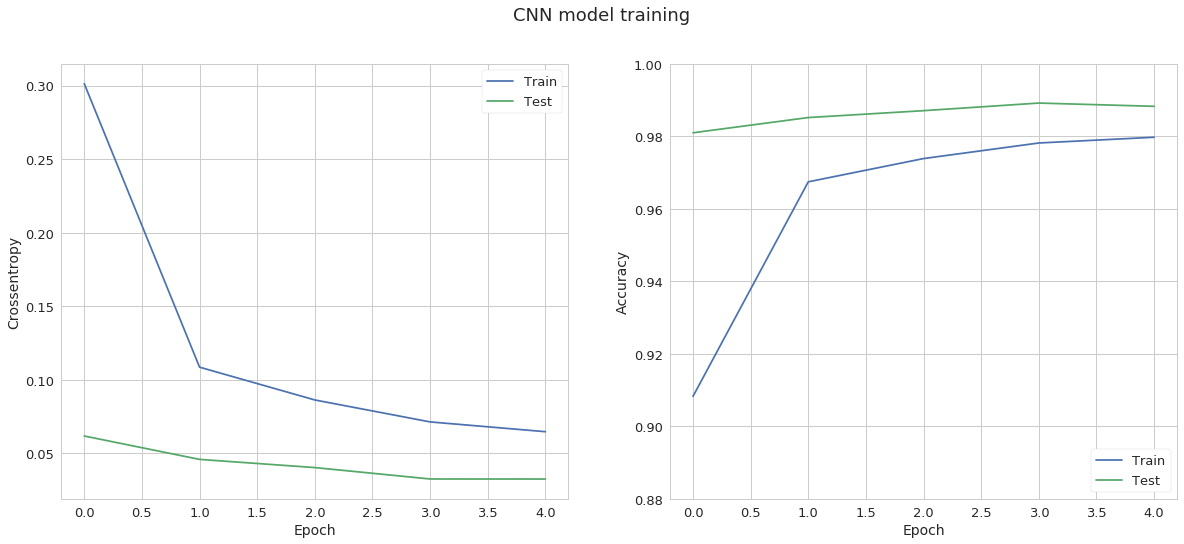

In [34]:
plt.figure(figsize=(20, 8))
plt.suptitle("CNN model training", fontsize=18)
plt.subplot(121)
plt.plot(hist.history["loss"], label="Train")
plt.plot(hist.history["val_loss"], label="Test")
plt.grid("on")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Crossentropy", fontsize=14)
plt.legend(loc="upper right")
plt.subplot(122)
plt.plot(hist.history["acc"], label="Train")
plt.grid("on")
plt.plot(hist.history["val_acc"], label="Test")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(loc="lower right")
plt.ylim([0.88, 1.0]);

Final evaluation of the model:

In [35]:
score_train = model_cnn.evaluate(X_train, y_train, verbose=0)
score_test = model_cnn.evaluate(X_test, y_test, verbose=0)

In [36]:
results.loc[len(results)] = np.array([score_train[1], score_test[1], score_train[0], score_test[0]])
results.index = ["MLP", "CNN"]

In [37]:
results

,Accuracy Train,Accuracy Test,Loss Train,Loss Test
MLP,0.9862,0.9746,0.045773,0.090305
CNN,0.9934,0.9883,0.021616,0.032652
